In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import KNNImputer

import seaborn as sns

# Read Dataset

In [2]:
train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
print("train size: {}, test size: {}".format(train.shape, test.shape))

train_id = train['id']
test_id = test['id']

train.head()

train size: (3960, 82), test size: (20, 59)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


# Preprocess Dataset

## Remove data in train that do not have sii

In [5]:
# Remove data in train that do not have sii
train = train.dropna(subset=['sii'])
target = train['sii']

print(train.shape, target.shape)

(2736, 82) (2736,)


## Find and remove data that exist in train but not in test

In [6]:
# Look for columns than do not exist in test and remove columns in train
test_missing_columns = set(train.columns) - set(test.columns)
print(test_missing_columns)

for column in test_missing_columns:
    train.drop(columns=column, inplace=True)

{'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'sii', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_Total', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_09', 'PCIAT-Season', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_10'}


## Remove columns that have large percentage of missing data

In [7]:
# Remove columns that have less than threshold of avaliable data
threshold = 40

train_non_missing = train.notnull().mean() * 100
test_non_missing = test.notnull().mean() * 100

columns_to_keep = list(train_non_missing[(train_non_missing >= threshold) & (test_non_missing >= threshold)].index)

print(columns_to_keep)

train = train[columns_to_keep]
test = test[columns_to_keep]

['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']


## Map data contain season to number

In [8]:
# Map season(Spring, Summer, Fall, Winter) to number
season_mapping = {
    'Spring': 0,
    'Summer': 1,
    'Fall': 2,
    'Winter': 3
}
train = train.replace(season_mapping)
test = test.replace(season_mapping)

## Fill Na data

In [9]:
# Fill with 0
train_na_0 = train.fillna(0)
train_na_0 = train_na_0.replace(season_mapping)

# # Fill with mean of columns
# train_numeric_cols = train.select_dtypes(include=['number']).columns
# test_numeric_cols = test.select_dtypes(include=['number']).columns
# train_mean = train
# test_mean = test
# train_mean[train_numeric_cols] = train[train_numeric_cols].fillna(train[train_numeric_cols].mean())
# test_mean[test_numeric_cols] = test[test_numeric_cols].fillna(test[test_numeric_cols].mean())


# train_mean = train_mean.replace(season_mapping)
# test_mean = test_mean.replace(season_mapping)
# train_mean = train_mean.fillna(0)
# test_mean = test_mean.fillna(0)

In [10]:
# Fill with KNN Imputer
imputer = KNNImputer(n_neighbors=4)  # k=4
imputed_train_data = imputer.fit_transform(train.drop(columns='id'))
imputed_test_data = imputer.fit_transform(test.drop(columns='id'))

train_knn = pd.DataFrame(imputed_train_data, columns=train.drop(columns='id').columns)
test_knn = pd.DataFrame(imputed_test_data, columns=test.drop(columns='id').columns)

## Correlation Matrix

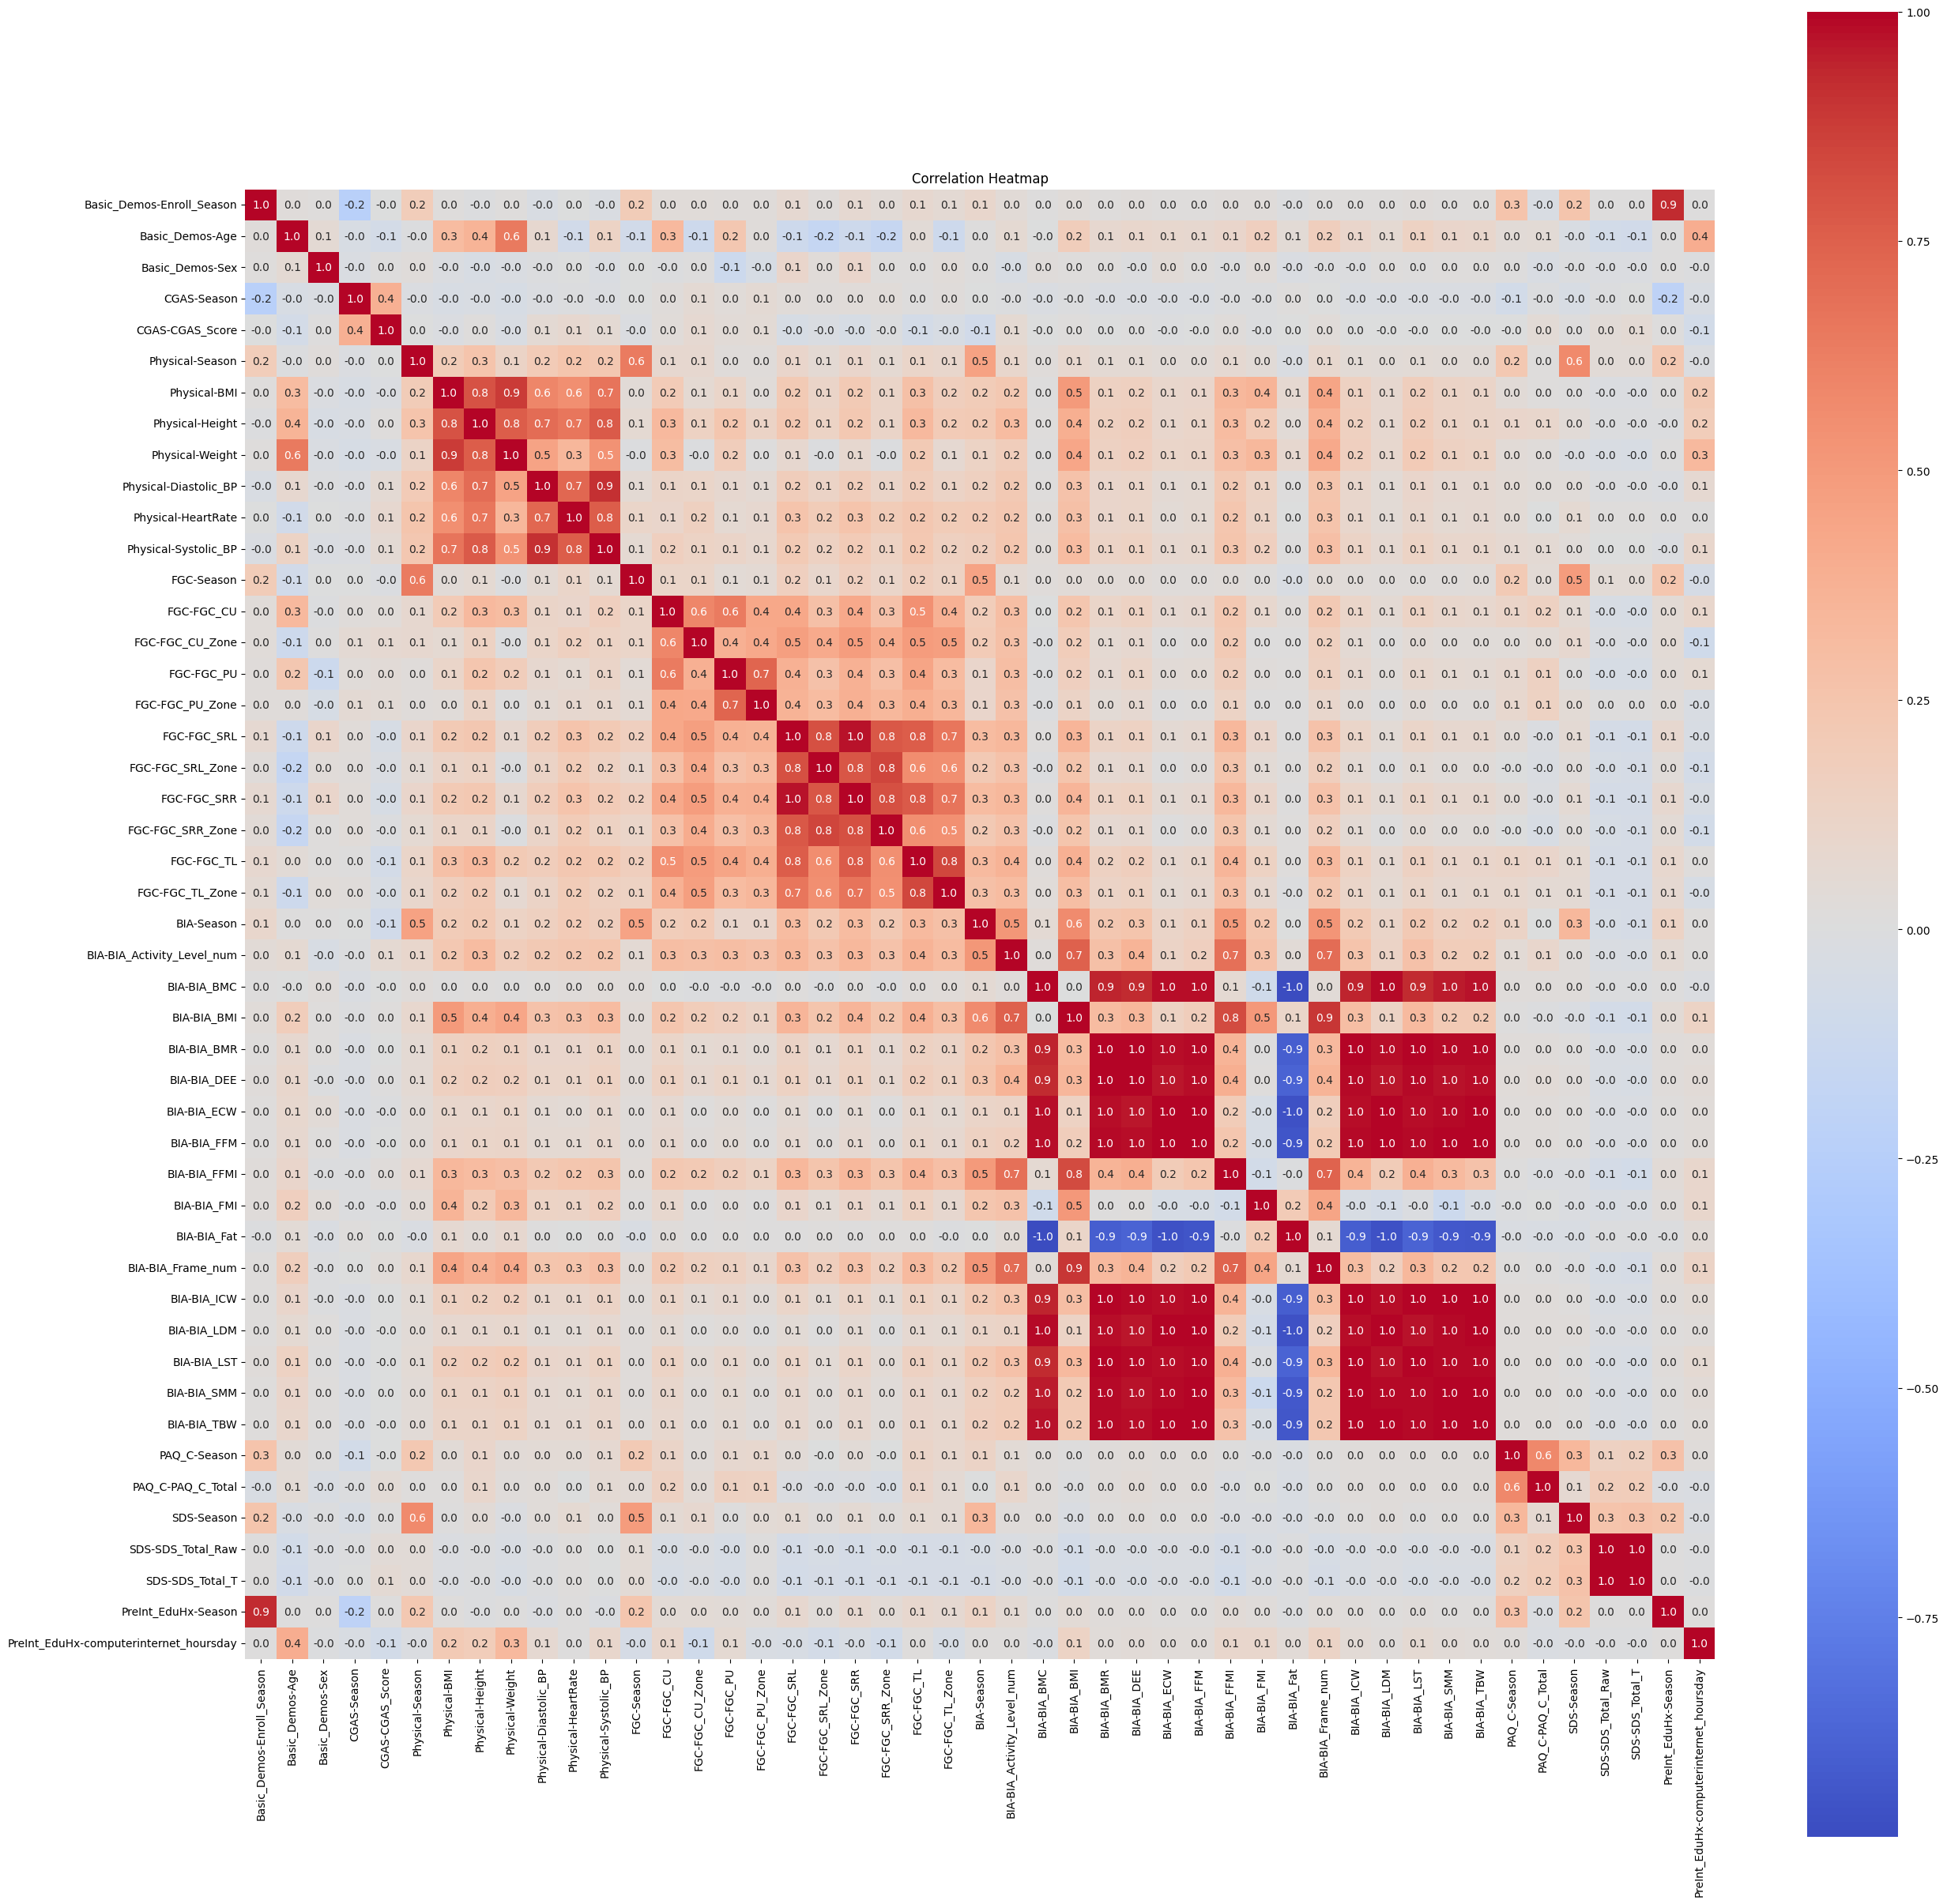

In [11]:
train_no_id = train_na_0.drop(columns='id')
correlation_matrix = train_no_id.corr()
# Plot the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# Models

In [12]:
# X_train = train_mean.drop(columns=['id', 'Basic_Demos-Enroll_Season', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone','BIA-BIA_BMC', 'BIA-BIA_Fat'])
# X_test = test_mean.drop(columns=['id', 'Basic_Demos-Enroll_Season', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone','BIA-BIA_BMC', 'BIA-BIA_Fat'])

# X_train = train_mean.drop(columns=['id'])
# X_test = test_mean.drop(columns=['id'])

X_train = train_knn
X_test = test_knn

y_train = target

In [13]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)

In [14]:
# Split dataset
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [15]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_t_train_scaled = scaler.fit_transform(X_t_train)
X_t_test_scaled = scaler.fit_transform(X_t_test)

In [16]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_t_train_pca = pca.fit_transform(X_t_train)
X_t_test_pca = pca.fit_transform(X_t_test)

In [17]:
# Random Forest
model = RandomForestClassifier(random_state=80)
model.fit(X_train_pca, y_train)

rf_model = RandomForestClassifier(random_state=80)
rf_model.fit(X_t_train_pca, y_t_train)

RandomForestClassifier(random_state=80)

# Model Evaluation

In [18]:
y_pred = rf_model.predict(X_t_test_pca)

print(classification_report(y_t_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.65      0.66       509
         1.0       0.26      0.28      0.27       193
         2.0       0.20      0.20      0.20       107
         3.0       0.25      0.08      0.12        12

    accuracy                           0.50       821
   macro avg       0.34      0.30      0.31       821
weighted avg       0.50      0.50      0.50       821



# Create submission

In [19]:
y_pred = model.predict(X_test_pca)

submission = pd.DataFrame({
    'id'  : test_id,
    'sii' : y_pred
})

# Save to CSV file
submission.to_csv('submission.csv', index=False)
submission

,id,sii
0,00008ff9,0.0
1,000fd460,0.0
2,00105258,0.0
3,00115b9f,1.0
4,0016bb22,0.0
5,001f3379,1.0
6,0038ba98,0.0
7,0068a485,0.0
8,0069fbed,0.0
9,0083e397,0.0
